In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import ydf
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
)

faults_raw = pd.read_csv(
    "../data/J1939Faults.csv", dtype={"EquipmentID": str, "spn": int}
)
diagnostics_raw = pd.read_csv("../data/vehiclediagnosticonboarddata.csv")
# prepare faults
faults_drop_cols = [
    "actionDescription",
    "activeTransitionCount",
    "eventDescription",
    "ecuSource",
    "ecuSoftwareVersion",
    "ecuModel",
    "ecuMake",
    "faultValue",
    "MCTNumber",
    "LocationTimeStamp",
]
faults = faults_raw.drop(columns=faults_drop_cols)


In [2]:
print("\n\n--------SHAPE OF FAULTS--------")
print(faults.shape)
# join diagnostics
print("--------NaNs--------")
print(diagnostics_raw.isna().sum())
n_ids = len(diagnostics_raw["Id"])
n_unique_id = diagnostics_raw["Id"].nunique()
n_un_faults = diagnostics_raw["FaultId"].nunique()
diagnostics_raw["Value"] = diagnostics_raw["Value"].replace(
    {"FALSE": False, "TRUE": True}
)

# pivot diagnostics to long format
diagnostics = diagnostics_raw.pivot(
    index="FaultId", columns="Name", values="Value"
)

print(f"\nlen(Id): {n_ids}", f"\nN unique_Id: {n_unique_id}")
print("\n--------RECORD ID vs FAULT ID--------")
print(
    f"n_unique FaultID: {n_un_faults}",
    f"\nn_unique RecordID: {faults['RecordID'].nunique()}",
)
joined = faults.merge(
    diagnostics, how="inner", left_on="RecordID", right_on="FaultId"
)
joined_pre_station_filter = joined
# filter out near service stations
joined_pre_station_filter = joined
print("Labeling faults near service stations...")
stations = pd.DataFrame(
    {
        "lat": [36.0666667, 35.5883333, 36.1950],
        "lon": [-86.4347222, -86.4438888, -83.174722],
    }
)
threshold_miles = 0.5
threshold_meters = threshold_miles * 1609.34
# create geodataframes with geopandas
gdf_joined = gpd.GeoDataFrame(
    joined,
    geometry=gpd.points_from_xy(joined.Latitude, joined.Longitude),
    crs="EPSG:4326",  # WGS84 coord ref sys (lat/lon)
)
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.lat, stations.lon),
    crs="EPSG:4326",
)
target_crs = "EPSG:9311"
# reproject onto new crs for better distance measurement
gdf_joined_proj = gdf_joined.to_crs(target_crs)
gdf_stations_proj = gdf_stations.to_crs(target_crs)
# create buffers around stations
station_buf = gdf_stations_proj.geometry.buffer(threshold_meters)
combined_buffer = (
    station_buf.union_all()
)  # turns into single geometry which helps with efficiency
is_within = gdf_joined_proj.geometry.within(combined_buffer)
joined["nearStation"] = is_within.values
joined = joined[~joined["nearStation"]]
print("\nDone! \nFaults within 1km of service station labeled in 'joined'.")
print(
    f"When filtered, this removes {len(joined['RecordID']) - len(joined['RecordID'])} rows"
)
# filter out active=False
joined_active = joined[joined["active"]]
joined = joined_active
print(
    f"\nNumber of rows after filtering active=False out: {len(joined_active['active'])}"
)
print(
    f"Rows removed: {len(joined_pre_station_filter['RecordID']) - len(joined_active['active'])}"
)
target_spn = 5246

# Ensure EventTimeStamp is datetime
joined["EventTimeStamp"] = pd.to_datetime(joined["EventTimeStamp"])

# SORTING STEP
# Sort by EquipmentID and then chronologically by EventTimeStamp
print("Sorting data by EquipmentID and EventTimeStamp...")
joined = joined.sort_values(by=["EquipmentID", "EventTimeStamp"]).copy()
print("Sorting complete.")

# Create a Series containing only the timestamps of trigger events
trigger_timestamps_only = joined["EventTimeStamp"].where(
    joined["spn"] == target_spn
)

# For each row, find the timestamp of the *next* trigger event within its group
# Group by EquipmentID and use backward fill (bfill)
# This fills NaT values with the next valid timestamp in the group
print("Calculating next trigger time...")
joined["next_trigger_time"] = trigger_timestamps_only.groupby(
    joined["EquipmentID"]
).bfill()

# Calculate the start of the 2-hour window before the next trigger
joined["window_start_time"] = joined["next_trigger_time"] - pd.Timedelta(
    hours=2.0
)

# Label rows as True if their timestamp falls within the window:
#    [wind`ow_start_time, next_trigger_time]
#    Also ensure that a next_trigger_time actually exists (it's not NaT)
print("Labeling derate window...")
joined["derate_window"] = (
    (joined["EventTimeStamp"] >= joined["window_start_time"])
    & (joined["EventTimeStamp"] <= joined["next_trigger_time"])
    & (joined["next_trigger_time"].notna())
)

# Verification
print("\nVerification:")
print(
    "Value counts for 'derate_window':\n",
    joined["derate_window"].value_counts(),
)
print(
    "\nValue counts for 'spn' (to confirm target SPN exists):\n",
    joined["spn"].value_counts(),
)

# Display some rows where derate_window is True (if any)
print("\nSample rows where derate_window is True:")
print(
    joined[joined["derate_window"]][
        ["EquipmentID", "EventTimeStamp", "spn", "next_trigger_time"]
    ].head()
)


joined = joined.drop(
    columns=[
        # "next_trigger_time",
        # "window_start_time",
        "CruiseControlActive",
        "AcceleratorPedal",
        "DistanceLtd",
        "FuelLevel",
        "ParkingBrake",
        "SwitchedBatteryVoltage",
        "RecordID",
        "ESS_Id",
        "ecuSerialNumber",
        "CruiseControlSetSpeed",
        "IgnStatus",
        "LampStatus",
        "IntakeManifoldTemperature",
        "ServiceDistance",
    ]
)
# some feature engineering:
joined["time_since_last_fault"] = (
    joined.groupby("EquipmentID")["EventTimeStamp"]
    .diff()
    .dt.total_seconds()
    .astype(float)
)
print(joined["time_since_last_fault"])
joined["fault_frequency"] = joined.groupby("EquipmentID")["spn"].transform(
    "count"
)
col_order = [
    "EquipmentID",
    "EventTimeStamp",
    "next_trigger_time",
    "window_start_time",
    "spn",
    "fmi",
    "active",
    "derate_window",
    "time_since_last_fault",
    "fault_frequency",
    "Latitude",
    "Longitude",
    "nearStation",
    "Speed",
    "BarometricPressure",
    "EngineCoolantTemperature",
    "EngineLoad",
    "EngineOilPressure",
    "EngineOilTemperature",
    "EngineRpm",
    "EngineTimeLtd",
    "FuelLtd",
    "FuelRate",
    "FuelTemperature",
    "Throttle",
    "TurboBoostPressure",
]
joined = joined[col_order]
joined.columns
print(joined.dtypes)
comma_sub_cols = [
    "Speed",
    "BarometricPressure",
    "EngineCoolantTemperature",
    "EngineLoad",
    "EngineOilPressure",
    "EngineOilTemperature",
    "EngineRpm",
    "FuelRate",
    "FuelTemperature",
    "Throttle",
    "TurboBoostPressure",
    "EngineTimeLtd",
    "FuelLtd",
]

for col in comma_sub_cols:
    joined[col] = joined[col].str.replace(",", ".", regex=True)

dtypes = {
    "EquipmentID": object,
    "EventTimeStamp": "datetime64[ns]",
    "spn": int,
    "fmi": int,
    "active": bool,
    "derate_window": bool,
    "time_since_last_fault": float,
    "fault_frequency": int,
    "Latitude": float,
    "Longitude": float,
    "nearStation": bool,
    "Speed": float,
    "BarometricPressure": float,
    "EngineCoolantTemperature": float,
    "EngineLoad": float,
    "EngineOilPressure": float,
    "EngineOilTemperature": float,
    "EngineRpm": float,
    "EngineTimeLtd": float,
    "FuelLtd": float,
    "FuelRate": float,
    "FuelTemperature": float,
    "Throttle": float,
    "TurboBoostPressure": float,
}
joined = joined.astype(dtype=dtypes)
for col in joined.columns:
    if joined[col].dtype == "bool":
        joined[col] = joined[col].astype(int)
print(joined.dtypes)
# EquipmentID and EventTimeStamp will ultimately be dropped before being run through the model, they're just our grouping variables mostly.
print(joined.isna().sum())
print(joined["Throttle"].value_counts())
for col in joined.columns:
    if joined[col].dtype == "int64" or joined[col].dtype == "float64":
        joined[col] = joined[col].bfill().ffill()
print(joined.isna().sum())




--------SHAPE OF FAULTS--------
(1187335, 10)
--------NaNs--------
Id         0
Name       0
Value      0
FaultId    0
dtype: int64

len(Id): 12821626 
N unique_Id: 12821626

--------RECORD ID vs FAULT ID--------
n_unique FaultID: 1187335 
n_unique RecordID: 1187335
Labeling faults near service stations...

Done! 
Faults within 1km of service station labeled in 'joined'.
When filtered, this removes 0 rows

Number of rows after filtering active=False out: 549008
Rows removed: 638327
Sorting data by EquipmentID and EventTimeStamp...
Sorting complete.
Calculating next trigger time...
Labeling derate window...

Verification:
Value counts for 'derate_window':
 derate_window
False    548064
True        944
Name: count, dtype: int64

Value counts for 'spn' (to confirm target SPN exists):
 spn
111       174649
929       115784
96         44398
829        43350
639        16172
           ...  
521032         1
4380           1
781            1
442            1
54478          1
Name: count, L

### separate data into pre and post 2019

In [3]:
joined['EventTimeStamp']

1001106   2018-07-20 09:31:33
358800    2016-01-31 07:12:25
927313    2018-01-26 18:58:08
936445    2018-02-12 20:29:39
936451    2018-02-12 20:33:23
                  ...        
1157136   2019-11-12 00:24:39
4245      2015-02-24 13:45:06
4427      2015-02-24 15:31:17
6438      2015-02-26 13:12:11
4952      2015-02-25 06:08:43
Name: EventTimeStamp, Length: 549008, dtype: datetime64[ns]

In [4]:
joined_pre_2019 = joined[joined['EventTimeStamp'].dt.year < 2019]
joined_post_2019 = joined[joined['EventTimeStamp'].dt.year >= 2019]

### check to see how many derates happen after 2019

In [5]:
derates_2019 = joined[(joined['spn'] == 5246) & (joined['EventTimeStamp'] > '12-31-2018')].copy() # & (joined['active'] == True)
derates_2019['derate_gap'] = derates_2019.sort_values(by=['EquipmentID', 'EventTimeStamp']).groupby('EquipmentID')['EventTimeStamp'].diff()
gap = pd.to_timedelta("24 hours")
confirmed_derates_2019 = derates_2019[(derates_2019.derate_gap.isnull()) | (derates_2019['derate_gap'] > gap)]
print(f"Goal for predicting derates: {len(confirmed_derates_2019)} derates to predict")

Goal for predicting derates: 43 derates to predict


### label predictors

In [6]:
# --- Define Predictors and Target ---
predictors = [
    col
    for col in joined_pre_2019.columns
    if col
    not in [
        "EquipmentID",
        "EventTimeStamp",
        "derate_window",
        "next_trigger_time",
        "window_start_time",
        "nearStation",
        "Latitude", 
        "Longitude",
        "active",
    ]
]
target = "derate_window"

### I need to set training data to joined_pre_2019 and test data to joined_post_2019

In [7]:
# # below should is the original setup before manually setting train and test data which is done in the next cell
# # prepare data for splitting
# X = joined_pre_2019[predictors]
# y = joined_pre_2019[target]

# # storing this for later use calculating which True Positives are more than 2 hours out
# original_test_info = joined[
#     [
#         "EventTimeStamp",
#         "next_trigger_time",
#         "derate_window",
#         "EquipmentID",
#         "spn",
#     ]
# ].copy()


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, stratify=y, test_size=0.3, random_state=42
# )


In [8]:
# --- Prepare Training and Testing Data ---
print("Preparing training (pre-2019) and testing (post-2019) data...")
X_train = joined_pre_2019[predictors]
y_train = joined_pre_2019[target]

X_test = joined_post_2019[predictors]
y_test = joined_post_2019[target]

# Storing necessary info from the original TEST set for evaluation
original_test_info = joined_post_2019[
    [
        "EquipmentID",
        "EventTimeStamp",
        "spn",
        "next_trigger_time", # Time of the SPN 5246 event
        "derate_window", # Actual label
    ]
].copy()
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Preparing training (pre-2019) and testing (post-2019) data...
Training data shape: (492397, 17)
Test data shape: (56611, 17)


In [9]:
# --- Train the Model ---
# Concatenate features and target for ydf training
train_df = pd.DataFrame(X_train)
train_df["derate_window"] = y_train
# test_df for prediction only needs features initially
test_df_predict = X_test.copy()

# Adjustments for model improvement
print("\nStarting model training with tuned hyperparameters...")
model = ydf.GradientBoostedTreesLearner(
    label="derate_window",  # Target column name
    task=ydf.Task.CLASSIFICATION,
    num_trees=500,
    max_depth=10,
    shrinkage=0.1,  # A common starting learning rate
    l2_regularization=0.01,  # ridge regression
    subsample=0.8,  # Use 80% of data per tree
    # Add random_seed for reproducibility if desired
    # random_seed=42
).train(train_df)
print("Model training complete.")


Starting model training with tuned hyperparameters...
Train model on 492397 examples
Model trained in 0:00:25.038037
Model training complete.


In [17]:
# --- Make Predictions ---
print("\nMaking predictions on the test set...")
# Get probability predictions
y_pred_proba = model.predict(test_df_predict)
# Convert probabilities to class predictions using a 0.5 threshold
y_pred_class = (y_pred_proba > 0.5).astype(int)

# --- Prepare Results Dataframe for Analysis ---
print("Preparing results dataframe for detailed analysis...")
# Create a dataframe for analysis using the original test set info
# Ensure index alignment is correct
test_results = original_test_info.copy()
test_results["predicted_derate"] = pd.Series(y_pred_class, index=X_test.index)

# Calculate time until the actual trigger event
test_results["time_until_trigger"] = (
    test_results["next_trigger_time"] - test_results["EventTimeStamp"]
)

# --- Calculate Derate Gaps (Time Since Last Actual Derate) ---
print("Calculating time gaps between actual derate events...")
# Identify actual derate trigger events in the test set
actual_triggers = joined_post_2019[joined_post_2019["spn"] == target_spn].copy()
actual_triggers = actual_triggers.sort_values(
    by=["EquipmentID", "EventTimeStamp"]
)

# Calculate time since the previous trigger for the same equipment
actual_triggers["derate_gap"] = actual_triggers.groupby("EquipmentID")[
    "EventTimeStamp"
].diff()

# Define the 24-hour threshold
derate_reset_period = pd.Timedelta(hours=24)

# Add the derate_gap to the test_results dataframe
# We merge based on the actual trigger time ('next_trigger_time' in test_results
# corresponds to 'EventTimeStamp' in actual_triggers)
test_results = pd.merge(
    test_results,
    actual_triggers[["EquipmentID", "EventTimeStamp", "derate_gap"]],
    left_on=["EquipmentID", "next_trigger_time"],
    right_on=["EquipmentID", "EventTimeStamp"],
    how="left",
    suffixes=("", "_trigger"), # Add suffix to avoid column name clash
)
# Drop the redundant EventTimeStamp_trigger column from the merge
test_results = test_results.drop(columns=["EventTimeStamp_trigger"])

print("Derate gap calculation complete.")

# --- Identify Valuable True Positives (for Savings) ---
print("\n--- Identifying Valuable True Positives (Savings Calculation) ---")
two_hours = pd.Timedelta(hours=2)

# Conditions for a valuable TP:
# - Model predicted derate (predicted_derate == 1)
# - It's actually a derate window (derate_window == 1) - Standard TP definition
# - The prediction was made more than 2 hours before the trigger (time_until_trigger > 2 hours)
# - The actual trigger event ('next_trigger_time') occurred > 24 hours after the previous one
#    (derate_gap > 24 hours OR derate_gap is NaT, meaning it's the first one)

valuable_TPs = test_results[
    (test_results["predicted_derate"] == 1)
    & (test_results["derate_window"] == 1) # Ensure it's a true positive
    & (test_results["time_until_trigger"].notna())
    & (test_results["time_until_trigger"] > two_hours)
    & (
        (test_results["derate_gap"].isna()) # First derate for equipment
        | (test_results["derate_gap"] > derate_reset_period) 
     )
].copy()

# count unique actual derate events that were successfully predicted early
# Group by the actual trigger event and check if any prediction within that group met the criteria
valuable_TP_events = valuable_TPs.drop_duplicates(subset=['EquipmentID', 'next_trigger_time'])
valuable_TP_count = len(valuable_TP_events)

print(
    f"Found {valuable_TP_count} unique actual derate events predicted >2 hours early with >{derate_reset_period} gap."
)


Making predictions on the test set...
Preparing results dataframe for detailed analysis...
Calculating time gaps between actual derate events...
Derate gap calculation complete.

--- Identifying Valuable True Positives (Savings Calculation) ---
Found 0 unique actual derate events predicted >2 hours early with >1 days 00:00:00 gap.


In [21]:
# --- Identify Costly False Positives (for Costs) ---
print("\n--- Identifying Costly False Positives (Cost Calculation) ---")

# all false positives
false_positives = test_results[
    (test_results["predicted_derate"] == 1)
    & (test_results["derate_window"] == 0)
].copy()

# trigger times
actual_trigger_times_map = (
    actual_triggers.groupby("EquipmentID")["EventTimeStamp"]
    .apply(list)
    .to_dict()
)

# 3. Define the function to find time to nearest actual trigger
def time_to_nearest_trigger(row, trigger_map):
    equipment_id = row["EquipmentID"]
    fp_timestamp = row["EventTimeStamp"]
    # Handle cases where equipment ID might not be in the map
    if equipment_id not in trigger_map or not trigger_map[equipment_id]:
        # Return a large timedelta if no triggers exist for this equipment
        return pd.Timedelta(days=999)

    trigger_times = trigger_map[equipment_id]
    # Calculate absolute time differences
    time_diffs = [abs(fp_timestamp - trigger_time) for trigger_time in trigger_times]
    # Return the minimum difference
    return min(time_diffs) # time_diffs will not be empty here due to check above

# Initialize count and dataframe for initial costly FPs
costly_FP_count = 0
initial_costly_FPs = pd.DataFrame()

# 4. Calculate time to nearest actual trigger and filter
if len(false_positives.index) > 0:
    print("Calculating time difference between false positives and nearest actual derate...")
    false_positives["time_to_nearest_actual"] = false_positives.apply(
        time_to_nearest_trigger, args=(actual_trigger_times_map,), axis=1
    )

    # Filter FPs that are more than 24 hours away from ANY actual trigger
    initial_costly_FPs = false_positives[
        false_positives["time_to_nearest_actual"] > derate_reset_period
    ].copy()
    print(f"Found {len(initial_costly_FPs)} individual FP rows > {derate_reset_period} from any actual derate.")

else:
    print("No false positives found.")
    # initial_costly_FPs remains empty


# --- NEW STEP: Filter clustered costly FPs ---
if len(initial_costly_FPs.index) > 0:
    print(f"Filtering clustered costly FPs (keeping only those > {derate_reset_period} apart)...")
    # Ensure sorting for the diff calculation
    initial_costly_FPs = initial_costly_FPs.sort_values(
        by=["EquipmentID", "EventTimeStamp"]
    )

    # Calculate time since the *previous costly FP* for the same equipment
    initial_costly_FPs["time_since_last_costly_fp"] = (
        initial_costly_FPs.groupby("EquipmentID")["EventTimeStamp"].diff()
    )

    # Keep a costly FP if it's the first one for the equipment (NaT)
    # OR if it occurred more than 24 hours after the previous costly FP
    final_costly_FPs = initial_costly_FPs[
        (initial_costly_FPs["time_since_last_costly_fp"].isna())
        | (initial_costly_FPs["time_since_last_costly_fp"] > derate_reset_period)
    ]

    costly_FP_count = len(final_costly_FPs)
else:
    # If initial_costly_FPs was empty, the count remains 0
    print("No initial costly FPs found to filter for clustering.")
    costly_FP_count = 0


print(
    f"Found {costly_FP_count} final costly False Positive events (separated by > {derate_reset_period})."
)


--- Identifying Costly False Positives (Cost Calculation) ---
Calculating time difference between false positives and nearest actual derate...
Found 8 individual FP rows > 1 days 00:00:00 from any actual derate.
Filtering clustered costly FPs (keeping only those > 1 days 00:00:00 apart)...
Found 3 final costly False Positive events (separated by > 1 days 00:00:00).



--- Standard Evaluation Metrics ---

Calculating macro F1 score (sklearn)...
Macro F1 Score: 0.8598

Classification Report (sklearn):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56523
           1       0.87      0.61      0.72        88

    accuracy                           1.00     56611
   macro avg       0.94      0.81      0.86     56611
weighted avg       1.00      1.00      1.00     56611


Confusion Matrix (sklearn):


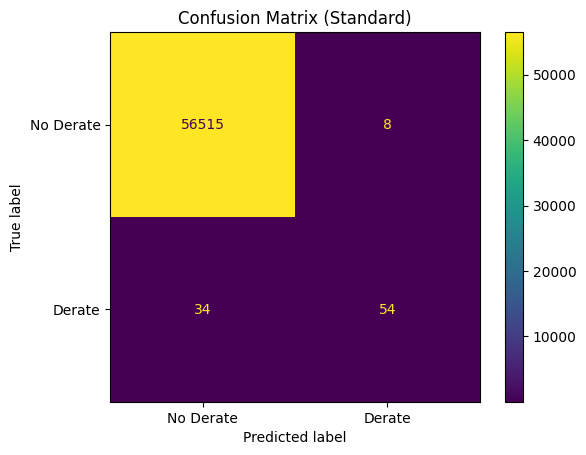

In [19]:

# --- Standard Evaluation Metrics (for comparison) ---
print("\n--- Standard Evaluation Metrics ---")
# Note: ydf evaluate needs the target column in the test_df
test_df_eval = X_test.copy() # Start with features
test_df_eval["derate_window"] = y_test # Add actual labels

# Evaluate using sklearn's f1_score (using y_test and y_pred_class)
print("\nCalculating macro F1 score (sklearn)...")
# Ensure y_test and y_pred_class are aligned if indices were shuffled (shouldn't be here)
macro_f1 = f1_score(y_test, y_pred_class, average="macro")
print(f"Macro F1 Score: {macro_f1:.4f}")

# Print classification report and confusion matrix for more detail
print("\nClassification Report (sklearn):")
# Use the actual labels from the test set and the predicted classes
print(classification_report(y_test, y_pred_class, zero_division=0))

print("\nConfusion Matrix (sklearn):")
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["No Derate", "Derate"]
)
disp.plot()
plt.title("Confusion Matrix (Standard)")
# Show confusion matrix plot
plt.show()


In [23]:
# Standard TP/FP from confusion matrix for comparison
TN_standard = cm[0, 0]
FP_standard = cm[0, 1]
FN_standard = cm[1, 0]
TP_standard = cm[1, 1] # All TPs within the 2hr window, regardless of gap/timing

print("Standard Confusion Matrix Counts:")
print(f"  True Negatives (TN): {TN_standard}")
print(f"  False Positives (FP): {FP_standard}")
print(f"  False Negatives (FN): {FN_standard}")
print(f"  True Positives (TP): {TP_standard}  <-- target for this is derate window")

Net_standard = (TP_standard * 4000) - (FP_standard * 500)
print(f"\nNet savings based on standard evaluation (all TPs, all FPs): ${Net_standard}")
print(f"\nGoal for predicting derates (from previous script): {len(confirmed_derates_2019)} derates to predict") # Print the goal again
print(f"Actual correctly predicted derates: {len(valuable_TP_events)} :(") # Print the actual number of correctly predicted derates

# --- Calculate Final Cost/Savings ---
print("\n--- Final Cost/Savings Analysis ---")
Savings = valuable_TP_count * 4000
Costs = costly_FP_count * 500
Net_Savings = Savings - Costs

print(f"Valuable True Positives (Savings): {valuable_TP_count}")
print(f"Costly False Positives (Costs): {costly_FP_count}")
print(f"Total Savings: ${Savings}")
print(f"Total Costs: ${Costs}")
print(f"Net Savings (Custom Definition): ${Net_Savings}")

Standard Confusion Matrix Counts:
  True Negatives (TN): 56515
  False Positives (FP): 8
  False Negatives (FN): 34
  True Positives (TP): 54  <-- target for this is derate window

Net savings based on standard evaluation (all TPs, all FPs): $212000

Goal for predicting derates (from previous script): 43 derates to predict
Actual correctly predicted derates: 0 :(

--- Final Cost/Savings Analysis ---
Valuable True Positives (Savings): 0
Costly False Positives (Costs): 3
Total Savings: $0
Total Costs: $1500
Net Savings (Custom Definition): $-1500
